In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Import numpy library for mathematical operations
import numpy as np

# Import bioservices module, to run remote UniProt queries
from bioservices import UniProt
# Import StringIO to handle the conversion of string to dataframe
from io import StringIO

### Read Network Data

In [2]:
# opening the interactome file
file_name= "data\\PathLinker_2018_human-ppi-weighted-cap0_75.txt"
pathLinker_file = open (file_name , 'r')

In [3]:
# reading the header line
header_line = pathLinker_file.readline()
# reading the data lines
data_lines = pathLinker_file.readlines()

In [4]:
header_line

'#tail\thead\tedge_weight\tedge_type\n'

In [5]:
header_line.rstrip().split('\t')[0:3]

['#tail', 'head', 'edge_weight']

### Converting to DataFrame

In [6]:
# looping over the data lines and extracting the tail, head and weight of each edge
weighed_edges_list=[]
for line in data_lines:
    tail,head = (line.split('\t'))[0:2]
    edge_weight = eval((line.split('\t'))[2])
    weighed_edges_list.append((tail , head , edge_weight))

In [7]:
print(f'Our network consists of {len(weighed_edges_list)} protein interactions.')

Our network consists of 612516 protein interactions.


In [8]:
# Create DataFrame
weighted_edges_df = pd.DataFrame(weighed_edges_list, columns =['Tail', 'Head', 'Edge_weight'])
weighted_edges_df

,Tail,Head,Edge_weight
0,Q8TBF5,Q9UKB1,0.311133
1,Q8TBF4,Q15717,0.311133
2,Q8TBF4,P08865,0.311133
3,Q8TBF4,Q02539,0.311133
4,Q8TBF4,Q96J01,0.201461
...,...,...,...
612511,Q17RB8,Q969G2,0.608042
612512,Q17RB8,Q06710,0.181552
612513,Q17RB8,P15374,0.280419
612514,Q17RB8,Q5JST6,0.608042


In [9]:
# calculate the number of unique proteins in the network
unique_tails = weighted_edges_df['Tail'].unique()
unique_heads = weighted_edges_df['Head'].unique()
unique_proteins = list(set(unique_tails).union(set(unique_heads)))

In [10]:
print('Network Observations')
print('-'*100)
print(f" Our network has {len(unique_tails)} unique tails: {unique_tails}")
print('-'*100)
print(f" Our network has {len(unique_heads)} unique heads: {unique_heads}")
print('-'*100)
print(f" Our network has {len(unique_proteins)} unique proteins")
print('-'*100)

Network Observations
----------------------------------------------------------------------------------------------------
 Our network has 17082 unique tails: ['Q8TBF5' 'Q8TBF4' 'Q5MIZ7' ... 'Q7Z739' 'Q17RB8' 'Q3LFD5']
----------------------------------------------------------------------------------------------------
 Our network has 17095 unique heads: ['Q9UKB1' 'Q15717' 'P08865' ... 'Q008S8' 'Q8N4T0' 'Q8IXL9']
----------------------------------------------------------------------------------------------------
 Our network has 17168 unique proteins
----------------------------------------------------------------------------------------------------


As the number of heads is very close to the number of tails, we may assume that the network is balanced. and this assumption can lead to several insights:
- Network stability: A balanced PPI network is likely to be more stable and less prone to disruption than an imbalanced network.
- Symmetrical interactions: The equal number of unique tails and heads suggests that the interactions in the network are symmetrical and that proteins are likely to be interacting with each other in a reciprocal manner.
- Functionality: Proteins in a balanced PPI network are likely to be playing *similar roles* in the network, regardless of their specific interactions.
- Lack of dominant hub proteins: If a network is balanced, it is less likely to have a *small number* of highly connected hub proteins that dominate the network.
- Redundancy: A balanced PPI network is likely to have a high degree of redundancy, with many proteins having similar interactions and functional roles.

### Construct Biological Network Graph

In [11]:
# initialize the graph
DG = nx.DiGraph()
DG.add_weighted_edges_from(weighed_edges_list)

In [12]:
# Take a sample of 100 interaction to be visually appealing
sample_DG = nx.DiGraph()
sample_DG.add_weighted_edges_from(weighed_edges_list[:300])

In [13]:
pos = nx.spring_layout(sample_DG)

Text(0.5, 0.98, 'PPI Network Sample')

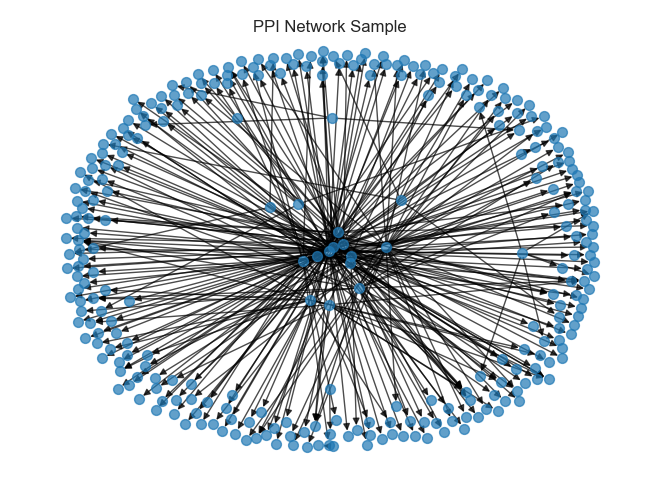

In [14]:
# drawing graph of 100 edges
nx.draw(sample_DG, pos,  node_size=50, edge_color='black', width=1, alpha=0.7)
plt.suptitle("PPI Network Sample")

#### List the acyclic shortest path(s) between two proteins in a text file.

In [15]:
# extracting K-shortest paths between two proteins
weighted_shortest_paths= ([p for p in nx.all_shortest_paths(DG, source="P20933", target="Q15303", weight='weight')])
weighted_shortest_paths

[['P20933', 'Q9Y3A3', 'Q68CZ1', 'P04637', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P04637', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'O15259', 'P22681', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P22681', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q96ST8', 'P46108', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P46108', 'Q15303']]

1- Provide the total path score.

In [16]:
# calculating the total shortest path score
total_path_score = nx.shortest_path_length(DG,source="P20933", target="Q15303", weight='weight')
total_path_score

0.6889442

2- Provide the weight of each interaction in the path(s).

In [17]:
# constructing the sub-network of the shortest path
sub_network = nx.DiGraph()
all_paths_edges = []
print('The weight of each interaction in the path(s)')
print("-"*150)
# looping over the shortest paths to be added to the sub-network
for shortest_path in weighted_shortest_paths :
    paths_edges = [tuple([shortest_path[i],shortest_path[i+1],nx.path_weight(DG,([shortest_path[i],shortest_path[i+1]]), weight ='weight')]) for i in range(len(shortest_path)-1)]
    print(paths_edges)
    # add path edges to the new sub-network
    sub_network.add_weighted_edges_from(paths_edges)
    all_paths_edges.append(paths_edges)
    print("-"*150)

The weight of each interaction in the path(s)
------------------------------------------------------------------------------------------------------------------------------------------------------
[('P20933', 'Q9Y3A3', 0.311133), ('Q9Y3A3', 'Q68CZ1', 0.0333391), ('Q68CZ1', 'P04637', 0.0333391), ('P04637', 'Q15303', 0.311133)]
------------------------------------------------------------------------------------------------------------------------------------------------------
[('P20933', 'Q9Y3A3', 0.311133), ('Q9Y3A3', 'Q6ZU80', 0.0333391), ('Q6ZU80', 'P04637', 0.0333391), ('P04637', 'Q15303', 0.311133)]
------------------------------------------------------------------------------------------------------------------------------------------------------
[('P20933', 'Q9Y3A3', 0.311133), ('Q9Y3A3', 'O15259', 0.0333391), ('O15259', 'P22681', 0.0333391), ('P22681', 'Q15303', 0.311133)]
------------------------------------------------------------------------------------------------------------

3- If more than one path, report all the paths.

In [18]:
for i, path in enumerate(weighted_shortest_paths):
    print(f'path{i} is: {path}')
"""
This code is iterating through the list weighted_shortest_paths and printing each path with a path number (path0, path1, etc.). The enumerate function adds an index to each element in the list, which is stored in the variable i. The path is stored in the variable path. The final output is generated using string formatting, with the f'path{i} is: {path}' statement
"""

path0 is: ['P20933', 'Q9Y3A3', 'Q68CZ1', 'P04637', 'Q15303']
path1 is: ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P04637', 'Q15303']
path2 is: ['P20933', 'Q9Y3A3', 'O15259', 'P22681', 'Q15303']
path3 is: ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P22681', 'Q15303']
path4 is: ['P20933', 'Q9Y3A3', 'Q96ST8', 'P46108', 'Q15303']
path5 is: ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P46108', 'Q15303']


"\nThis code is iterating through the list weighted_shortest_paths and printing each path with a path number (path0, path1, etc.). The enumerate function adds an index to each element in the list, which is stored in the variable i. The path is stored in the variable path. The final output is generated using string formatting, with the f'path{i} is: {path}' statement\n"

4- Draw the sub-network formed by these shortest paths.

All shortest paths between protein P20933 & Q15303:


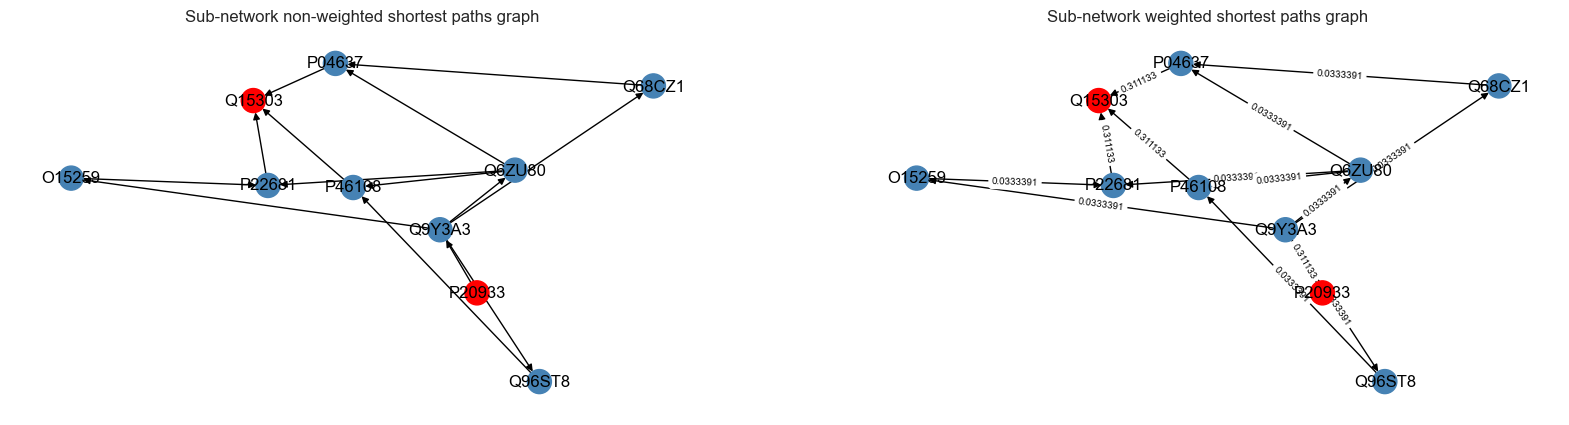

In [19]:
# This code block is for visualizing the shortest paths between two protein nodes in a sub-network.
# Create the position layout of the sub-network
pos = nx.spring_layout(sub_network)

# Get the edge weight labels for the sub-network
sub_weight_labels = nx.get_edge_attributes(sub_network,'weight')

# Print a statement to show the result of the code
print(f'All shortest paths between protein P20933 & Q15303:')

# Define the two nodes that are being analyzed
two_nodes = ['P20933', 'Q15303']

# Set the color of the nodes in the sub-network
# Steelblue for all nodes except the source and target proteins which are red
node_col = ['steelblue' if not node in two_nodes else 'red' for node in sub_network.nodes()]

# Create a figure of size 20x5 inches
fig = plt.figure(figsize=(20, 5))

# Subplot 1: non-weighted shortest paths graph
plt.subplot(1, 2, 1)
# Draw the non-weighted shortest paths graph
nx.draw(sub_network, pos, with_labels = True, node_color = node_col)
# Add a title to the subplot
plt.title('Sub-network non-weighted shortest paths graph')

# Subplot 2: weighted shortest paths graph
plt.subplot(1, 2, 2)
# Draw the weighted shortest paths graph
nx.draw(sub_network, pos, with_labels = True, node_color = node_col)
# Draw the edge weight labels for the sub-network
nx.draw_networkx_edge_labels(sub_network, pos, font_size=7, edge_labels=sub_weight_labels)
# Add a title to the subplot
plt.title('Sub-network weighted shortest paths graph')

# Save the figure as an image
fig.savefig('images\\shortest_paths_subnetwork.png')

In [20]:
# The code writes the shortest paths and the total path score to a file
# First, it creates a string `first_line` that contains information about the source and target proteins,
# and the number of shortest paths between them.

shortest_paths_number = len(weighted_shortest_paths)
source = "P20933"
target = "Q15303"
first_line = f"Shortest paths between {source} and {target} Proteins\n\nNumber of shortest paths :{shortest_paths_number}"

# The file `shortest_path_file` is opened for writing, and `first_line` and the total path score are written to the file.

shortest_path_file = open ("data\\acyclic_shortest_path.txt",'w')
shortest_path_file.write(first_line)
shortest_path_file.write("\nTotal path score : %f \n\n" %total_path_score)

# The code then loops over the shortest paths (`weighted_shortest_paths`) and writes information about each path to the file.
# For each path, the nodes are concatenated and written to the file as a string.
# Then the edges weights of each path are written to the file.

for idx ,shortest_path in enumerate(weighted_shortest_paths):
    shortest_path_file.write(f"Path {idx} : \n")
    nodes_joined = " > ".join(shortest_path)
    shortest_path_file.write(f"{nodes_joined} ")
    shortest_path_file.write("\n\n\tTail\tHead\tEdge_weight\n")
    for edges in all_paths_edges[idx]:
        shortest_path_file.write(f"\t{edges[0]}\t{edges[1]}\t{edges[2]}\n")
    shortest_path_file.write("\n")

# Finally, the file is closed.
shortest_path_file.close()

### List all the directly connected proteins to a given one protein in a text file.
- Report the degree (number of connections) of this protein in a separate line.
- Provide each connected protein in a line with its corresponding interaction weight.

In [21]:
given_protein = "Q5MIZ7"

In [22]:
# get the successors of the given protein
successors = [n for n in DG.successors(given_protein)]
# printing the number of successors and the list of successors
print(f'The out Degree for the given protein is {len(successors)} and the proteins where the given protein interact with are:\n{successors}')

# get the out-degree of the given protein
out_degree = DG.out_degree(given_protein)

The out Degree for the given protein is 33 and the proteins where the given protein interact with are:
['Q8N490', 'Q53ET0', 'P51648', 'P04629', 'P46379', 'P16104', 'Q99689', 'P62714', 'Q9H3S7', 'Q16719', 'Q86VU5', 'Q96LJ8', 'Q07866', 'P27348', 'Q9NR45', 'P07384', 'P30084', 'O75439', 'Q9H0B6', 'P33176', 'P62829', 'P35557', 'O60610', 'Q53H82', 'O14745', 'Q00839', 'Q13263', 'Q96KP4', 'Q9NY27', 'P60510', 'P21980', 'Q9BZF1', 'Q14103']


In [23]:
# Get the predecessors (incoming nodes) of the given protein
predecessors = [n for n in DG.predecessors(given_protein)]
# Print the in degree (number of incoming edges) and the list of predecessors
print(f'The in Degree for the given protein is {len(predecessors)} and the proteins that interacts with the given protein are:\n{predecessors}')
# Get the in degree of the given protein
in_degree = DG.in_degree(given_protein)

The in Degree for the given protein is 31 and the proteins that interacts with the given protein are:
['P62829', 'Q99689', 'O14745', 'P27348', 'P30084', 'Q86VU5', 'Q14103', 'P04629', 'Q96LJ8', 'Q00839', 'P35557', 'P60510', 'Q13263', 'P07384', 'Q9H3S7', 'Q53H82', 'Q9BZF1', 'O75439', 'O60610', 'P62714', 'Q07866', 'P21980', 'Q9NR45', 'Q96KP4', 'P46379', 'P51648', 'Q9NY27', 'Q9H0B6', 'Q8N490', 'P33176', 'Q16719']


In [24]:
# Printing the total degree of the given protein
# The total degree of a node is defined as the number of edges incident to it (in + out)

predecessors = [n for n in DG.predecessors(given_protein)]
successors = [n for n in DG.successors(given_protein)]
all_interacting_proteins = [*predecessors, *successors]

print(f'The total Degree for the given protein is {len(predecessors) + len(successors)} and the proteins that interacts with or the given protein interacts with are:\n{all_interacting_proteins}')

# Obtaining the degree of the given protein from the networkx method
all_degree = DG.degree(given_protein)

The total Degree for the given protein is 64 and the proteins that interacts with or the given protein interacts with are:
['P62829', 'Q99689', 'O14745', 'P27348', 'P30084', 'Q86VU5', 'Q14103', 'P04629', 'Q96LJ8', 'Q00839', 'P35557', 'P60510', 'Q13263', 'P07384', 'Q9H3S7', 'Q53H82', 'Q9BZF1', 'O75439', 'O60610', 'P62714', 'Q07866', 'P21980', 'Q9NR45', 'Q96KP4', 'P46379', 'P51648', 'Q9NY27', 'Q9H0B6', 'Q8N490', 'P33176', 'Q16719', 'Q8N490', 'Q53ET0', 'P51648', 'P04629', 'P46379', 'P16104', 'Q99689', 'P62714', 'Q9H3S7', 'Q16719', 'Q86VU5', 'Q96LJ8', 'Q07866', 'P27348', 'Q9NR45', 'P07384', 'P30084', 'O75439', 'Q9H0B6', 'P33176', 'P62829', 'P35557', 'O60610', 'Q53H82', 'O14745', 'Q00839', 'Q13263', 'Q96KP4', 'Q9NY27', 'P60510', 'P21980', 'Q9BZF1', 'Q14103']


In [25]:
# This code block writes the in-degree information of a given protein to a file
# Open a file with the name of the given protein followed by "_predecessors.txt"
protein_predecessors_file = open (f"data\\{given_protein}_predecessors.txt",'w')
# Write the in-degree information of the given protein to the file
protein_predecessors_file.write(f"{given_protein} In Degree = %d \n" %in_degree)
# Write the header information for the edges of the given protein
protein_predecessors_file.write("\nTail\tHead\tEdge_weight\n")
# Write the edge information for each of the predecessors of the given protein
for tail in predecessors:
    # Write the edge information with the format "tail node, head node, edge weight"
    protein_predecessors_file.write(f"{tail}\t{given_protein}\t{nx.path_weight(DG,(tail,given_protein), weight ='weight')}\n")
# Close the file
protein_predecessors_file.close()

In [26]:
# Saved text file
weighted_edges_df[weighted_edges_df["Head"]==given_protein]

,Tail,Head,Edge_weight
27817,P62829,Q5MIZ7,0.201461
31863,Q99689,Q5MIZ7,0.750000
34520,O14745,Q5MIZ7,0.201461
60461,P27348,Q5MIZ7,0.201461
122329,P30084,Q5MIZ7,0.201461
137890,Q86VU5,Q5MIZ7,0.311133
159380,Q14103,Q5MIZ7,0.311133
160235,P04629,Q5MIZ7,0.311133
195937,Q96LJ8,Q5MIZ7,0.311133
227489,Q00839,Q5MIZ7,0.201461


Conclusion: when in-degree is close to out-degree that can result in stability of overall network topological, thus some studies have suggested that a more stable network may decrease the probability of disease infection by providing more robust connections between proteins, reducing the risk of network failure and disease spread. However, this is not a universal trend and stability in network topology may not always result in decreased disease infection. Further research is needed to fully understand the relationship between network stability, network topology, and disease infection.

#### Given a set of proteins:
- Draw a histogram for the proteins degree.
- Rank these proteins from the highly connected to the least in a text file, where each line is a protein and its corresponding degree.

In [27]:
proteins_set = unique_proteins

In [28]:
# This code prints the in-degree, out-degree, and total-degree of a set of proteins
# in a directed graph 'DG'.

# Calculating the in-degree, out-degree, and total-degree of each node in the graph
in_degrees = [DG.in_degree(n) for n in proteins_set] # list of in-degree of each node
out_degrees = [DG.out_degree(n) for n in proteins_set] # list of out-degree of each node
degrees = [DG.degree(n) for n in proteins_set] # list of total-degree of each node

# printing the results
print(f'Corresponding to the given set of proteins\n \n, the in degree sample is {in_degrees[:10]}\n, the out degree sample is {out_degrees[:10]}\n, and the total degree sample is {degrees[:10]}\n')

Corresponding to the given set of proteins
 
, the in degree sample is [42, 7, 6, 1, 1, 1, 2, 152, 3, 33]
, the out degree sample is [41, 4, 6, 1, 1, 1, 2, 151, 3, 33]
, and the total degree sample is [83, 11, 12, 2, 2, 2, 4, 303, 6, 66]



In [29]:
# Creating a pandas dataframe from the list of proteins, in degrees, out degrees and total degrees
proteins_degrees = pd.DataFrame(list(zip(proteins_set, in_degrees, out_degrees, degrees)),columns =['Proteins', 'In_Degree' , 'Out_Degree',"Degrees"])

# Displaying the resulting dataframe
proteins_degrees

,Proteins,In_Degree,Out_Degree,Degrees
0,Q13564,42,41,83
1,P0C7T3,7,4,11
2,Q9BV35,6,6,12
3,P0DOY3,1,1,2
4,Q8N6K4,1,1,2
...,...,...,...,...
17163,O14807,47,31,78
17164,O60733,23,16,39
17165,Q9UKD2,62,61,123
17166,O94955,29,29,58


In [30]:
# Sort the dataframe by total degree in descending order
sorted_degrees = proteins_degrees.sort_values(by=['Degrees'], ascending=False)

# Display the sorted dataframe
sorted_degrees

,Proteins,In_Degree,Out_Degree,Degrees
3065,P05067,2083,2087,4170
9061,P04629,1989,1961,3950
3655,Q15717,1797,1800,3597
15691,P05412,1531,1521,3052
269,O14980,1232,1230,2462
...,...,...,...,...
11167,Q9UNA0,1,0,1
5432,Q9UEE5,0,1,1
14699,Q9Y5H3,1,0,1
7404,Q6UXV1,1,0,1


In [31]:
# Code to write the sorted protein degrees to a file named "proteins_degrees.txt".
# Opening the file for writing.
protein_degrees_file = open("data\\proteins_degrees.txt",'w')

# Writing the header for the columns "Protein" and "Degree" to the file.
protein_degrees_file.write("Protein\tDegree\n\n")

# Looping through the sorted_degrees dataframe to write each protein name and its degree.
for idx in sorted_degrees.index:
    # Writing the protein name and degree to the file in the format "protein_name    degree".
    protein_degrees_file.write(f"{sorted_degrees['Proteins'][idx]}\t{sorted_degrees['Degrees'][idx]}\n")

# Closing the file after all data has been written.
protein_degrees_file.close()

In [32]:
# Sample highest 10 proteins in total degree
sub_proteins_degrees = sorted_degrees.head(10)

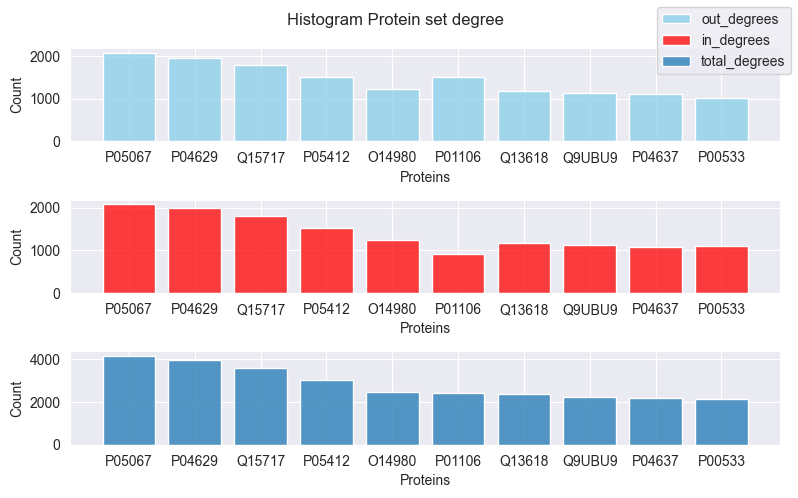

In [33]:
# Import seaborn library
import seaborn as sns

# Create a subplot with 3 subplots
fig, axs = plt.subplots(3, figsize=(8, 5))

# Plot the histogram of out_degrees
sns.histplot(data=sub_proteins_degrees, x="Proteins",  weights=sub_proteins_degrees["Out_Degree"] ,color="skyblue", label="out_degrees" , shrink=.8 , ax=axs[0])

# Plot the histogram of in_degrees
sns.histplot(data=sub_proteins_degrees, x="Proteins", weights=sub_proteins_degrees["In_Degree"], color="red", label="in_degrees" , shrink=.8, ax=axs[1])

# Plot the histogram of total_degrees
sns.histplot(data=sub_proteins_degrees, x="Proteins" , weights=sub_proteins_degrees["Degrees"] , shrink=.8, ax=axs[2], label='total_degrees')

# Add a title to the subplots
plt.suptitle('Histogram Protein set degree')

# Add a legend to the subplots
fig.legend()

# Adjust the layout of the subplots
fig.tight_layout()

# Save the subplots as an image
fig.savefig('images\\histogram_proteins_set')

- We can conclude that both `P05067` and `P04629` are hub proteins and maybe  key scaffold proteins.
    - We notice that P05067 & P04629 are hub proteins and may be key scaffold proteins (based on its protein complex), and as hub proteins play a central role in the organization and function of the network. The importance of hub proteins can be attributed to several factors, including:
        - Modularity: Hub proteins can act as central connectors between different modules or functional units in the network, allowing for effective communication and coordination of cellular processes.
        - Robustness: Hub proteins can provide stability to the network by forming multiple interactions with other proteins, making the network less susceptible to failure or perturbations.
        - Functionality: Hub proteins are often involved in multiple pathways and functions, making them crucial for the overall function of the cell.
        - Evolution: Hub proteins tend to evolve slowly and are conserved across species, suggesting their importance in the evolution and stability of cellular processes.
        - Disease: Disruptions in the interactions of hub proteins can have a significant impact on cellular processes and have been implicated in various diseases, such as cancer.
- So, our subnetwork is robust, modular, & stable. and their hub proteins have some characteristics:
    - P05067
        - Function
            - Functions as a cell surface receptor and performs physiological functions on the surface of neurons relevant to neurite growth, neuronal adhesion and axonogenesis. Interaction between APP molecules on neighboring cells promotes synaptogenesis Involved in cell mobility and transcription regulation through protein-protein interactions. Can promote transcription activation through binding to APBB1-KAT5 and inhibits Notch signaling through interaction with Numb. Couples to apoptosis-inducing pathways such as those mediated by G(o) and JIP. Inhibits G(o) alpha ATPase activity (By similarity).
        - Disease
            - Alzheimer’s disease 1 (AD1)
                - The disease is caused by variants affecting the gene represented in this entry.
                - Cerebral amyloid angiopathy, APP-related (CAA-APP), The disease is caused by variants affecting the gene represented in this entry.
        - Corresponding Gene
            - APP
    - P04629
        - Function
            - Receptor tyrosine kinase involved in the development and the maturation of the central and peripheral nervous systems through the regulation of proliferation, differentiation and survival of sympathetic and nervous neurons. High-affinity receptor for NGF which is its primary.
        - Disease
            - Congenital insensitivity to pain with anhidrosis (CIPA). The disease is caused by variants affecting the gene represented in this entry Characterized by congenital insensitivity to pain, anhidrosis (absence of sweating), absence of reaction to noxious stimuli, self-mutilating behavior, and intellectual disability.
        - Corresponding Gene
            - NTRK1


#### Provide a conversion map between the protein UniProt ID and its gene name.
- You can be provided by one protein ID or a set of protein IDs, and then you need to get their corresponding gene names.

In [34]:
# Make a link to the UniProt webservice
service = UniProt()
# Build a query string (try this a test)
query_1 = "P05067"
query_2 = "P04629"
# Send the query to UniProt, and catch the search result in a variable
result_1 = service.search(query_1)
result_2 = service.search(query_2)
# Create a dataframe from the first query result
df_gene_1 = pd.read_csv(StringIO(result_1), sep='\t')
# Create a dataframe from the second query result
df_gene_2 = pd.read_csv(StringIO(result_2), sep='\t')
# Concatenate both dataframes into a single dataframe
df_genes = pd.concat([df_gene_1, df_gene_2])
# Display the final dataframe
df_genes

0it [00:00, ?it/s]
0it [00:00, ?it/s]


,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length
0,P05067,A4_HUMAN,reviewed,Amyloid-beta precursor protein (APP) (ABPP) (A...,APP A4 AD1,Homo sapiens (Human),770
0,P04629,NTRK1_HUMAN,reviewed,High affinity nerve growth factor receptor (EC...,NTRK1 MTC TRK TRKA,Homo sapiens (Human),796


In [35]:
# Create a link to the UniProt web service
service = UniProt()
# Define an empty list to store the gene names
gene_names = []
# Get the list of UniProt IDs from the sub_proteins_degrees dataframe
UniProt_IDs = list(sub_proteins_degrees.iloc[:, 0]).copy()
# Loop through each UniProt ID in the list
for ID in UniProt_IDs:
    # Send the query to UniProt and store the result
    result = service.search(ID)
    # Convert the result into a pandas dataframe using the tab separator
    gene_df = pd.read_csv(StringIO(result), sep='\t')
    # Append the gene name of the current ID to the gene_names list
    gene_names.append(gene_df['Gene Names'])
# Print the UniProt IDs and the corresponding gene names
print(f'Proteins are\n {UniProt_IDs}\n Corresponding genes are {gene_names}')

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Proteins are
 ['P05067', 'P04629', 'Q15717', 'P05412', 'O14980', 'P01106', 'Q13618', 'Q9UBU9', 'P04637', 'P00533']
 Corresponding genes are [0    APP A4 AD1
Name: Gene Names, dtype: object, 0    NTRK1 MTC TRK TRKA
Name: Gene Names, dtype: object, 0    ELAVL1 HUR
Name: Gene Names, dtype: object, 0    JUN
Name: Gene Names, dtype: object, 0    XPO1 CRM1
Name: Gene Names, dtype: object, 0    MYC BHLHE39
Name: Gene Names, dtype: object, 0    CUL3 KIAA0617
Name: Gene Names, dtype: object, 0    NXF1 TAP
Name: Gene Names, dtype: object, 0    TP53 P53
Name: Gene Names, dtype: object, 0    EGFR ERBB ERBB1 HER1
Name: Gene Names, dtype: object]


#### Create Adjacency Matrix
- From the network we created of shortest paths where “P20933” is the tail, “Q15303” is the head, and “0.6889442” is the weight cost.

In [36]:
# Create a copy of the weighted_shortest_paths data
data = weighted_shortest_paths.copy()
# Create a list of unique proteins from the data
unique_proteins = list(set([protein for sublist in data for protein in sublist]))
# Create an adjacency matrix of size (number of unique proteins x number of unique proteins)
adjacency_matrix = np.zeros((len(unique_proteins), len(unique_proteins)), dtype=int)
# Loop through each sublist of data to populate the adjacency matrix
for sublist in data:
    for i, protein1 in enumerate(sublist[:-1]):
        for j, protein2 in enumerate(sublist[i+1:], i+1):
            # Get the index of the protein1 and protein2 in the unique_proteins list
            protein1_index = unique_proteins.index(protein1)
            protein2_index = unique_proteins.index(protein2)
            # Set the corresponding indices in the adjacency matrix as 1 to represent a connection
            adjacency_matrix[protein1_index][protein2_index] = 1
            adjacency_matrix[protein2_index][protein1_index] = 1
# Print the adjacency matrix
print(adjacency_matrix)

[[0 1 1 1 1 1 0 1 0 0]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 0 1 0 0 1 0 1]
 [1 1 0 0 1 0 1 1 0 0]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 0 0 1 0 0 1 1 0]
 [0 1 0 1 1 0 0 1 0 0]
 [1 1 1 1 1 1 1 0 1 1]
 [0 1 0 0 1 1 0 1 0 0]
 [0 1 1 0 1 0 0 1 0 0]]


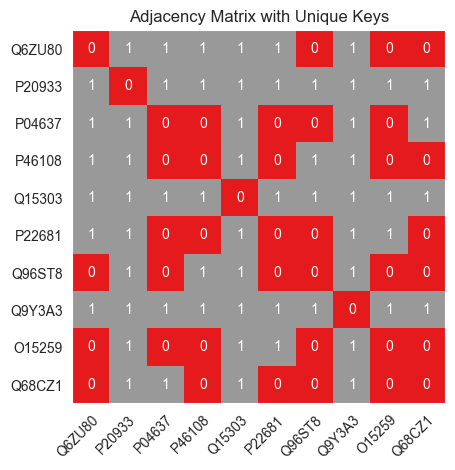

In [37]:
# Plotting the Adjacency Matrix
# Initializing a subplot with one figure and one axis
fig, ax = plt.subplots()

# Creating a heatmap of the adjacency matrix with 'Set1' color map
im = ax.imshow(adjacency_matrix, cmap='Set1')

# Setting the x-axis and y-axis ticks to the index of each protein
ax.set_xticks(np.arange(len(unique_proteins)))
ax.set_yticks(np.arange(len(unique_proteins)))

# Setting the x-axis and y-axis tick labels to the unique proteins
ax.set_xticklabels(unique_proteins)
ax.set_yticklabels(unique_proteins)

# Rotating the x-axis tick labels 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Adding the values from the adjacency matrix as text on the heatmap
for i in range(len(unique_proteins)):
    for j in range(len(unique_proteins)):
        text = ax.text(j, i, adjacency_matrix[i, j],
                       ha="center", va="center", color="w")

# Hiding the gridlines
ax.grid(False)

# Setting the title of the plot
ax.set_title("Adjacency Matrix with Unique Keys")

# Tightening the layout of the plot
fig.tight_layout()

# Saving the plot as an image file
fig.savefig('images\\adjacency_matrix.png')

Q9Y3A3 is the hub protein of this sub-network.

#### Members Contribution

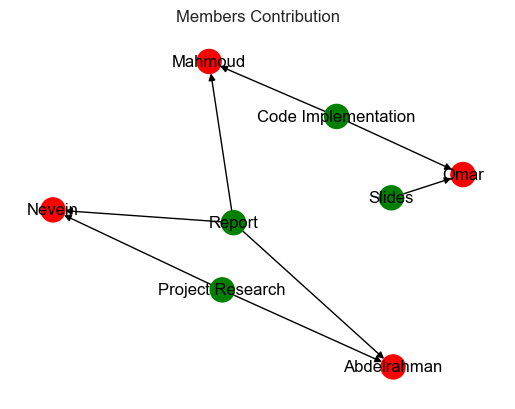

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty directed graph
G = nx.DiGraph()

# Add the main nodes (Slides, Report, Project Research, Code Implementation)
G.add_node("Code Implementation")
G.add_node("Project Research")
G.add_node("Report")
G.add_node("Slides")

# Add the sub-nodes (team members)
G.add_node("Mahmoud")
G.add_node("Omar")
G.add_node("Abdelrahman")
G.add_node("Nevein")

# Add the edges (connections) between the main and sub-nodes
G.add_edge("Code Implementation", "Mahmoud")
G.add_edge("Code Implementation", "Omar")
G.add_edge("Project Research", "Abdelrahman")
G.add_edge("Project Research", "Nevein")
G.add_edge("Report", "Abdelrahman")
G.add_edge("Report", "Mahmoud")
G.add_edge("Report", "Nevein")
G.add_edge("Slides", "Omar")

# Set colors for main and sub-nodes
colors = []
for node in G.nodes():
    if node in ["Code Implementation", "Project Research", "Report", "Slides"]:
        colors.append("green")
    else:
        colors.append("red")

# Draw the graph
fig, ax = plt.subplots()
plt.title('Members Contribution')
nx.draw(G, node_color=colors, with_labels=True)
plt.show()
fig.savefig('images\\members.png')